# NFTTime - The NFT Sale Price Predictor

A time series modeling tool to help you begin trading NFTs.

![Cryptopunk NFTs](images/nftshutter.jpg)

Author: Samantha Nasti

## Overview

NFTs, short for “non-fungible tokens”, are one of the hottest trending tradable commodities in the cryptocurrency space to date. To summarize, an NFT is a piece of digital artwork that exists on the blockchain. The [blockchain](https://www.investopedia.com/terms/b/blockchain.asp) is a distributed database that tracks the transaction history of a digital asset and makes the history of that asset unalterable – technology which is currently disrupting the payments industry. . The purchase of an NFT provides the buyer with verifiable ownership of the NFT purchased, and oftentimes access to additional benefits such as intellectual property rights and community perks. 

A single NFT typically belongs to a bigger collection by a particular artist or brand in the NFT ecosystem. Examples of popular NFT collections are Bored Ape Yacht Club and Cryptopunks, each containing 10,000 similarly-branded art tokens with unique individual properties. These collections have become so sought after that they have inspired the concept of NFT digital social club exclusivity, with each collection boasting A-list celebrity token owners and multi-million dollar ticket prices. 
Anyone can create an NFT, which has inspired and empowered thousands of artists to create collections 
and sell their art on Opensea, the first and largest NFT marketplace that just [crossed a 10 billion dollar sales volume](https://beincrypto.com/opensea-crosses-10-billion-in-all-time-sales-volumes/) in 2021. 

Additionally, contemporary art investments, with an annual return of 14%, have [outperformed the S&P 500](https://www.cnbc.com/2021/05/27/there-are-unique-opportunities-in-art-says-one-asset-manager.html) (9.5% annual return) over the last 25 years , according to the Citi Global Art Market chart. 
Considering the continuously surging volume of NFT sales, plus the history of average returns in contemporary art trading, there exists an incredible opportunity to diversify one’s portfolio and make generous returns in the highly liquid digital art space. 


#### Risks To Consider:
- Industry is new and uncertain: "long term hold" investment strategy is higher risk than short term gains
- Asset can be traded 24/7 - gap risk is intense ATM especially as space continues to develop "hype"

#### Purpose of this Model:
- Capture prices for NFT "flipping" (swing trading)
- Help NFT traders forecast what their NFT purchase might look like a week or two later to provide a baseline to assess the approximate risk in this highly volatile space

## Data

Opensea Events API: https://docs.opensea.io/reference/retrieving-asset-events

This model allows you to select an NFT collection of your choice on Opensea and generate a forecast of future sales price (in Ethereum).

I used the Opensea API to create a dataset for several different NFT collections (Cool Cats, Gutter Cat Gang, and Pudgy Penguins) to explore, test, and compare time series model performance on.

I collected a minimum of 10,000 observations of sales transactions for each collection. I only selected collections that were found in Opensea's Top NFTs (By Volume) stats list, since our goal is to sell for a profit within a short time frame.

I created a function to select an Opensea collection of your choice and extract 10,000 of the most recent sales observations with ease. All you need is the custom collection name, and an API key. 

In [123]:
#From Opensea, find the URL's tag associated with the collection, and insert into function as a string 
#Example: https://opensea.io/collection/mutantcats would insert "mutantcats" into this function
def pull_opensea_events(collection_name, api_key):

    events_list = []
    for i in range(0,10000,50):
        url = f"https://api.opensea.io/api/v1/events?only_opensea=true&collection_slug={collection_name}&occurred_before=2021-12-02T22:32:47.007226"
        querystring = {"offset":f"{i}","limit":"50", 'event_type': 'successful'}
        headers = {"X-API-KEY": "{api_key}"}
        response = requests.request("GET", url, headers=headers, params=querystring)
        json = response.json()
        df = json_normalize(json['asset_events'])
        events_list.append(df)
        print(f"Total {i} observations and {len(df)} observations added")
    collection_data = pd.concat([df for df in events_list], ignore_index=True, sort=False)
    print("")
    return collection_data

### Imports

In [122]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from pandas.io.json import json_normalize
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from sklearn.metrics import mean_squared_error
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from matplotlib.pylab import rcParams

### Data Preparation

I used the Opensea API's "Events" collection to pull collection-specific sales transactions for various different NFTs. I then wrote functions to convert the dataframe index to a datetime index, and then another function to clean the dataset for easier EDA and engineer our target variable to be a readable Ethereum sale price. 

Data collection, preparation, engineering and modeling was performed on 3 different NFT collections, but for purposes of demonstration, only one will be displayed in this notebook. 


In [6]:
#convert the dataframe to a datetime index
def opensea_to_dt(df): 
    df["created_date"] = pd.to_datetime(df["created_date"])
    df2 = df.set_index(df["created_date"])
    return df2

#convert prices to ETH figures
def fix_prices(price):
    return price * 9.999999999999999e-19


#function to drop nulls, create clean ETH price column, and drop irrelevant columns
def opensea_df_clean(df):
    df["total_price"].dropna(inplace=True)
    df["total_price"] = pd.to_numeric(df["total_price"], downcast="float", errors="coerce")
    df['total_price_eth'] = df["total_price"].apply(fix_prices)
    df_columns_keep = ["id", "quantity", "total_price_eth", "asset.id", "asset.token_id", "asset.num_sales", 
                   "asset.name", "seller.address", "transaction.block_hash", "transaction.block_number",
                  "transaction.id", "transaction.timestamp", "transaction.transaction_hash", "transaction.transaction_index",
                  "winner_account.address"]
    new_df = df[df_columns_keep]
    return new_df

After performing exploratory data analysis on my NFT of choice, I save the data as a CSV with my save_as_csv function so I can utilize it in different notebooks.

In [7]:
def save_as_csv(df, name):
#Takes in a dataframe and a filename specified by the user(as a string)'''
#Saves dataframe as a CSV file for import and use in other notebooks '''
    df.to_csv(name)
    return print("CSV saved")

### Data Exploration

Since I will be using this for several NFT collections, I am going to try to make the EDA process as seamless as possible by using another function. All NFT collections are going to have different sales history, but the columns of the API are the same which will make it easy for us to perform easy EDA functions uniformly.

The below function imports a data set from your machine (scraped from the Opensea Events API), turns the index into a datetime, and then prints exploratory data visualizations for a quick overview of what the selected collection looks like.

In [120]:
#this function imports a dataframe from your machine, turns the index into a datetime, and performs EDA functions
#you need to supply:
#csv_location is a string containing the location where your data is saved, for example: "data/NFTname.csv"
#your_df_name represents the name of the variable you want to save your dataframe to when you call the function
def starter_eda(csv_string):
    
    your_df_name = pd.read_csv(csv_string, index_col=0)
    your_df_name.index = pd.to_datetime(your_df_name.index)
    print("Data overview:")    
    print(your_df_name.describe())
    
    print("Historic sales data:")
    your_df_name["total_price_eth"].plot()
    
    #create datetime visualization columns
    your_df_name["year"] = your_df_name.index.year
    your_df_name["month"] = your_df_name.index.month
    your_df_name["hour"] = your_df_name.index.hour
    your_df_name["weekday"] = your_df_name.index.day_name()
    
    print("Amount of sales occurring on each day of the week:")
    #view sales stats for each day of the week
    weekdays = your_df_name["weekday"].value_counts()
    fig, ax = plt.subplots()
    x = weekdays.index
    y = weekdays
    sns.barplot(x=x, y=y)
    
    print("Amount of sales occurring historically per hour")    
    #view sales stats for each day of the week
    hourcounts = your_df_name["hour"].value_counts()
    fig, ax = plt.subplots()
    x = hourcounts.index
    y = hourcounts
    sns.barplot(x=x, y=y)
    
    return your_df_name

I will demonstrate some of the EDA performed pre-modeling with the Gutter Cat Gang NFT collection.

Data overview:
                 id      quantity  total_price_eth      asset.id  \
count  1.000000e+04  10000.000000     10000.000000  9.990000e+03   
mean   6.515127e+08      1.004700         5.663997  2.334913e+07   
std    4.566059e+08      0.228217        14.837597  1.654488e+05   
min    1.826182e+08      1.000000         0.000000  2.329564e+07   
25%    3.784922e+08      1.000000         2.500000  2.330542e+07   
50%    4.965954e+08      1.000000         3.968450  2.331632e+07   
75%    6.998351e+08      1.000000         5.550000  2.332241e+07   
max    2.268994e+09     20.000000      1000.000020  2.493355e+07   

       asset.token_id  asset.num_sales  transaction.block_number  \
count     9990.000000      9990.000000              1.000000e+04   
mean     10075.926527         2.818218              1.304846e+07   
std       5787.696225         1.575474              2.458497e+05   
min          3.000000         1.000000              1.253689e+07   
25%       4996.250000         2.

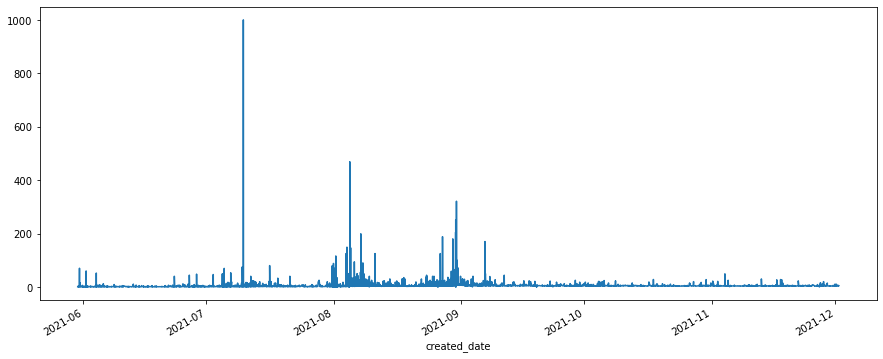

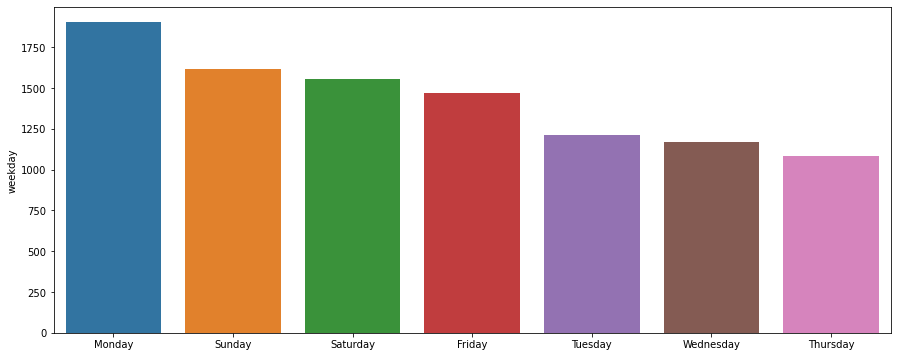

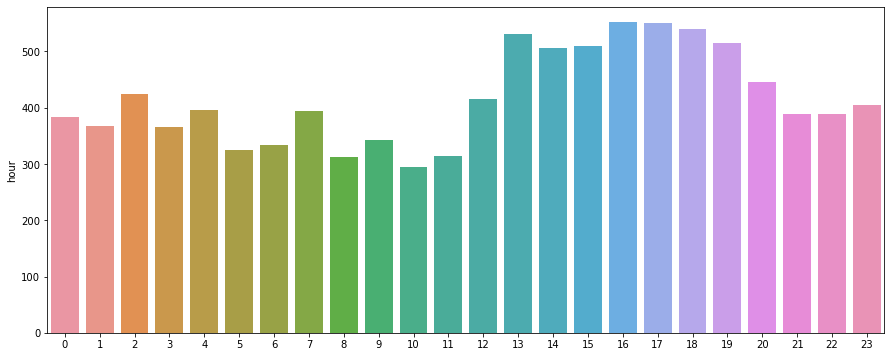

In [121]:
gcg = starter_eda("guttercats.csv")

### Pre-Processing

I will use this function to quickly remove any irrelevant observations, aka "sales" that are recorded at 0eth, which were most likely trades or wallet transfers. This function also resamples our data to collect the minimum sale price that happened every 4 hours.

In [25]:
#import a datetime indexed dataframe 
#function will drop any null sales (with 0 eth transaction), resample TS to lowest sale every 4 hours, fill nulls
def prep_to_model(dt):
    dropzero = dt[dt["total_price_eth"] == 0.0]
    dt.drop(dropzero.index, inplace=True)
    ts = dt["total_price_eth"].resample('4H').min()
    ready_ts = ts.bfill()
    return ready_ts 

I have tested modeling multiple collections on hourly, daily, and periodic samplings. The data that seems to perform the best with our models is the 4-hour minimum sale price sampling. 

In [26]:
gcg_ts = prep_to_model(gcg)

In [27]:
gcg_ts

created_date
2021-05-30 16:00:00    0.50000
2021-05-30 20:00:00    0.60000
2021-05-31 00:00:00    0.70000
2021-05-31 04:00:00    0.69000
2021-05-31 08:00:00    0.70000
                        ...   
2021-12-01 04:00:00    3.39000
2021-12-01 08:00:00    2.73013
2021-12-01 12:00:00    3.15000
2021-12-01 16:00:00    3.79900
2021-12-01 20:00:00    3.79900
Freq: 4H, Name: total_price_eth, Length: 1112, dtype: float64

### Model Baseline

Use our train-test split function to quickly split our data for modeling.

In [32]:
#train test split
def tts(ts):
    cutoff = round(ts.shape[0]*0.8)
    train = ts[:cutoff]
    test = ts[cutoff:]
    return train, test

In [33]:
train, test = tts(gcg_ts)

Take a quick look at the data split up to get an idea of which dates we will train on, and which we will end up predicting and verifying:

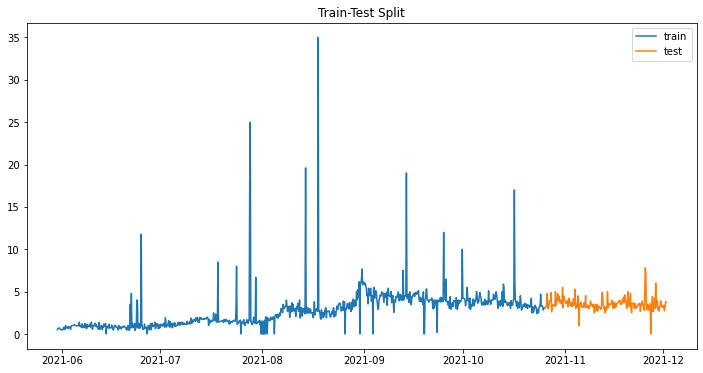

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

Now we will create a naive baseline model, which is our training set shifted one period, to get a starting RMSE score.

In [37]:
naive_baseline = train.shift(1)

Let's visualize what the naive baseline looks like compared to our original training data:

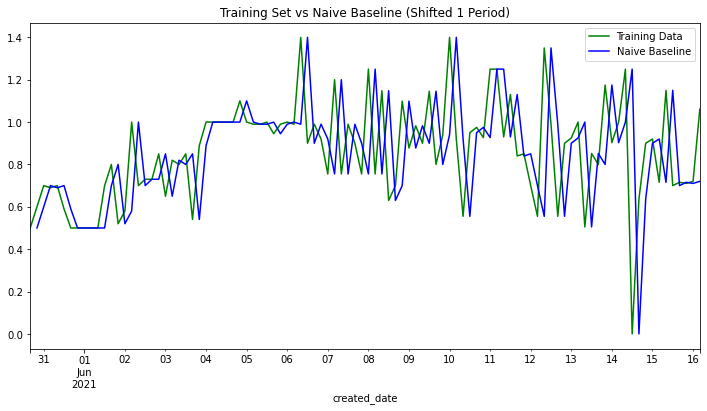

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))
train[0:100].plot(ax=ax, c='g', label='Training Data')
naive_baseline[0:100].plot(ax=ax, c='b', label='Naive Baseline')
ax.set_title('Training Set vs Naive Baseline (Shifted 1 Period)')
ax.legend();

Let's gather our first RMSE score:

In [42]:
np.sqrt(mean_squared_error(train[1:], naive_baseline.dropna()))

2.481025508114987

With a naive baseline score of 2.48, we now have the goal in mind to improve this score with our model as best as possible.

### Model Gridsearch

For each collection I run an auto-arima grid search to find the best parameters. Interestingly, after trying many data sets with grid searching, the best AIC performance scores appear when I set the seasonality parameter to "36". Perhaps this has something to do with the typical cyclical patterns existing in the NFT space, combined with the 4-hour sampling. So I am leaving the 36 seasonality as a default in our gridsearch.

In [43]:
#insert your time series-ready data
def gridsearch(ts):
    p = d = q = range(0,2)
    pdq = list(itertools.product(p,d,q))
    pdqs = [(x[0], x[1], x[2], 36) for x in list(itertools.product(p, d, q))]

#run all possible combinations, return parameters that provide the best AIC score
    paramlist = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                output = mod.fit()
                paramlist.append([comb, combs, output.aic])
                print('Arima {} x {}36 : AIC score ={}'.format(comb, combs, output.aic))
            except:
                continue
                
    param_df = pd.DataFrame(paramlist, columns=['pdq', 'pdqs', 'aic'])
    order_result = param_df.loc[param_df['aic'].idxmin()][0]
    seasonal_result = param_df.loc[param_df['aic'].idxmin()][1]
    print(param_df.loc[param_df['aic'].idxmin()])
    return order_result, seasonal_result

#make sure to save function as two parameters: order and seasonal, these will be fed into your create_model function next

In [44]:
def create_model(ts, order_result, seasonal_result): 
    arima = sm.tsa.statespace.SARIMAX(ts, order=order_result,  
                                      seasonal_order=seasonal_result,
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False)

    ts_model = arima.fit()
    print(ts_model.summary().tables[1])
    return ts_model

Let's run our gridsearch first:

In [45]:
order, seasonal = gridsearch(train)

Arima (0, 0, 0) x (0, 0, 0, 36)36 : AIC score =4791.481794567488
Arima (0, 0, 0) x (0, 0, 1, 36)36 : AIC score =4347.91008489091
Arima (0, 0, 0) x (0, 1, 0, 36)36 : AIC score =4185.722838846935
Arima (0, 0, 0) x (0, 1, 1, 36)36 : AIC score =3665.328935383277
Arima (0, 0, 0) x (1, 0, 0, 36)36 : AIC score =4065.1903161287605
Arima (0, 0, 0) x (1, 0, 1, 36)36 : AIC score =3800.6436440556467
Arima (0, 0, 0) x (1, 1, 0, 36)36 : AIC score =3813.94809310049
Arima (0, 0, 0) x (1, 1, 1, 36)36 : AIC score =3675.167564655907
Arima (0, 0, 1) x (0, 0, 0, 36)36 : AIC score =4394.475775329025
Arima (0, 0, 1) x (0, 0, 1, 36)36 : AIC score =4119.98182926617
Arima (0, 0, 1) x (0, 1, 0, 36)36 : AIC score =4159.494977059735
Arima (0, 0, 1) x (0, 1, 1, 36)36 : AIC score =3618.7042090081072
Arima (0, 0, 1) x (1, 0, 0, 36)36 : AIC score =3995.5736852319505
Arima (0, 0, 1) x (1, 0, 1, 36)36 : AIC score =3753.8180015268076
Arima (0, 0, 1) x (1, 1, 0, 36)36 : AIC score =3789.3039419166325
Arima (0, 0, 1) x (1, 

Now we are ready to input our gridsearch variables into our model and begin making predictions!

In [46]:
gcg_model = create_model(train, order, seasonal)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1575      0.015     10.307      0.000       0.128       0.188
ma.L1         -1.0286      0.014    -75.503      0.000      -1.055      -1.002
ma.S.L36      -1.0000    927.908     -0.001      0.999   -1819.666    1817.666
sigma2         3.6362   3374.135      0.001      0.999   -6609.548    6616.820


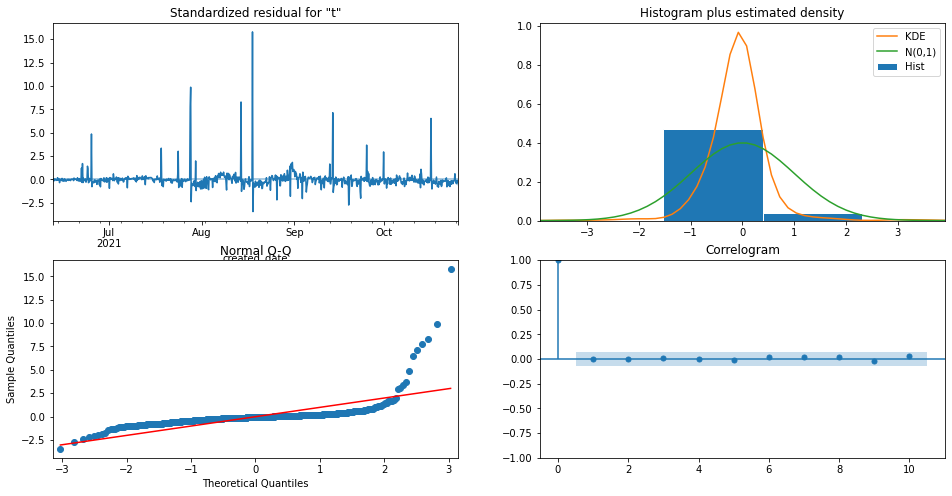

In [50]:
gcg_model.plot_diagnostics(figsize=(16,8));

I am not thrilled about the QQ quantiles and the distance between KDE vs N(0,1) plots in our diagnostic model assessment - this suggests the model residuals are not normally distributed, but since our ARIMA gridsearch suggested these parameters, I will continue forecasting to see how well it performs versus our baseline.

In [55]:
#gather non-dynamic predictions and confidence intervals
pred = gcg_model.get_prediction(start=pd.to_datetime('2021-07-01'), dynamic=False)
pred_conf = pred.conf_int()

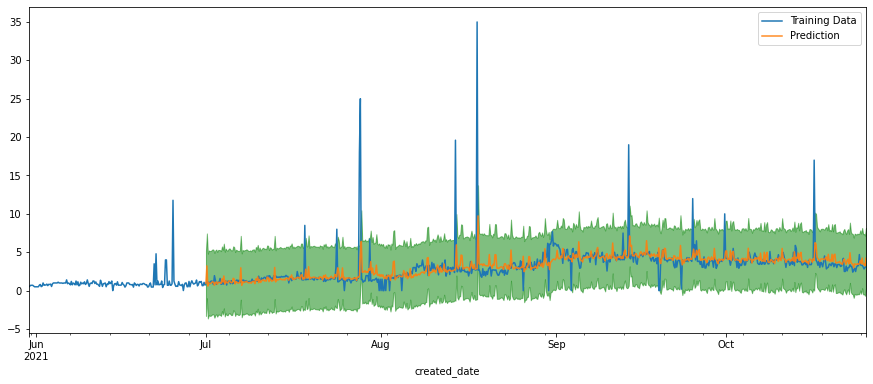

In [56]:
# Plot our real data vs predicted values along with confidence intervals
rcParams['figure.figsize'] = 15, 6
# Plot observed values
ax = train.plot(label='Training Data')
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)
plt.legend()
plt.show()

In [57]:
#Get RMSE of predictions from July until now
forecasted_values = pred.predicted_mean
true_values = train['2021-07-01':]

np.sqrt(mean_squared_error(true_values, forecasted_values))

2.149575753670586

In [58]:
#gather non-dynamic predictions and confidence intervals
pred = gcg_model.get_prediction(start=pd.to_datetime('2021-09-01'), dynamic=False)
pred_conf = pred.conf_int()

In [60]:
#Get RMSE of predictions from July until now
forecasted_values = pred.predicted_mean
true_values = train['2021-09-01':]

np.sqrt(mean_squared_error(true_values, forecasted_values))

1.5166012088889964

In [65]:
#gather non-dynamic predictions and confidence intervals
pred = gcg_model.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_conf = pred.conf_int()

In [66]:
#Get RMSE of predictions from July until now
forecasted_values = pred.predicted_mean
true_values = train['2021-10-01':]

np.sqrt(mean_squared_error(true_values, forecasted_values))

1.3052687540762316

I ran three different rounds of predictions and calculated the RMSE of our model's predictions vs our training data. The smaller we make our prediction range, aka predictions from October forward as opposed to July forward, the better our scores become. This must be due to the existing trend in our data and must be kept in mind.

Now let's begin forecasting with our model and later compare the results to our testing set.

In [124]:
#Create forecast using our model, specify how many periods we want to predict
future = gcg_model.get_forecast(steps=300)
# Get confidence intervals of forecasts
future_conf = future.conf_int()

In [125]:
#Let's see how far out these predictions go
future.predicted_mean

2021-10-26 00:00:00    3.264197
2021-10-26 04:00:00    4.092477
2021-10-26 08:00:00    4.460916
2021-10-26 12:00:00    3.403034
2021-10-26 16:00:00    3.224587
                         ...   
2021-12-14 04:00:00    4.384874
2021-12-14 08:00:00    4.187512
2021-12-14 12:00:00    4.183516
2021-12-14 16:00:00    4.064700
2021-12-14 20:00:00    4.488715
Freq: 4H, Name: predicted_mean, Length: 300, dtype: float64

Okay, we have predictions through the end of November which is great. Our test set is unseen by this model and we can compare the forecast with actual values. Then, we can assess the performance of our forecast, and consider the values predicted for the future.

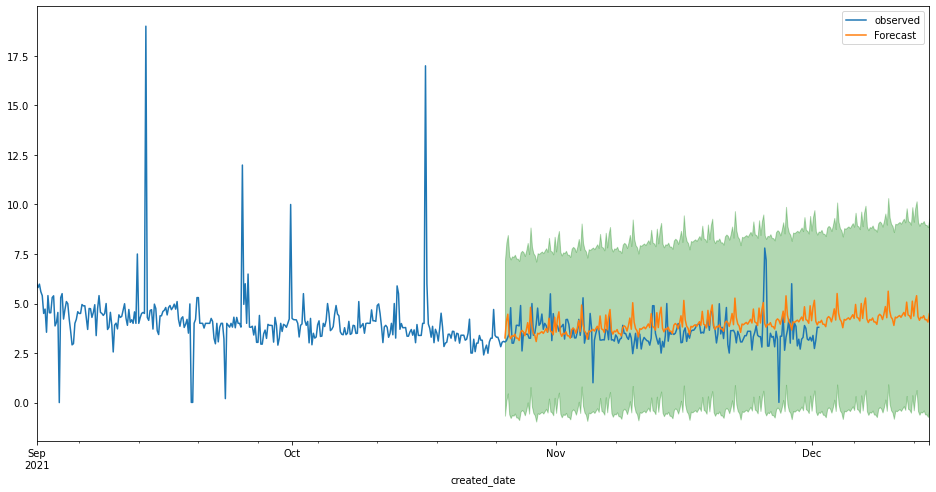

In [127]:
# Plot future predictions with confidence intervals
ax = gcg_ts["2021-09-01":].plot(label='observed', figsize=(16, 8))
future.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(future_conf.index,
                future_conf.iloc[:, 0],
                future_conf.iloc[:, 1], color='g', alpha=0.3)

plt.legend()
plt.show()

In [103]:
np.sqrt(mean_squared_error(test, future.predicted_mean[:222]))

0.9346694104142349

Our forecast, though improvable, is looking promising. Visualizing the forecasted values versus the actual, unseen test data, makes it clear that our forecast is not too far off. Our forecasted predictions are actually performing better on the unseen test data than when compared to the model predictions. 

We can use this forecast to make assisted NFT purchasing decisions. The model results allows us to assess today's purchase price of our NFT asset of interest, and then forecast the valuation of that NFT asset in the future. 

Let's demonstrate how this could look. At the time of writing, on 12/2/2021, the Gutter Cat Gang floor is: 3.98 ETH.

In [108]:
future.predicted_mean["2021-12-02"]

2021-12-02 00:00:00    4.040876
2021-12-02 04:00:00    4.152280
2021-12-02 08:00:00    3.954918
2021-12-02 12:00:00    3.950922
2021-12-02 16:00:00    3.832106
2021-12-02 20:00:00    4.256120
Freq: 4H, Name: predicted_mean, dtype: float64

Our model actually predicted very closely to today's current floor price when the data was unseen. Now we can predict what the floor price may look like in a week, or two weeks.

In [117]:
future.predicted_mean["2021-12-09"]

2021-12-09 00:00:00    4.457111
2021-12-09 04:00:00    4.387256
2021-12-09 08:00:00    4.191935
2021-12-09 12:00:00    4.473063
2021-12-09 16:00:00    4.847622
2021-12-09 20:00:00    4.283235
Freq: 4H, Name: predicted_mean, dtype: float64

In [115]:
future.predicted_mean["2021-12-14"]

2021-12-14 00:00:00    4.273470
2021-12-14 04:00:00    4.384874
2021-12-14 08:00:00    4.187512
2021-12-14 12:00:00    4.183516
2021-12-14 16:00:00    4.064700
2021-12-14 20:00:00    4.488715
Freq: 4H, Name: predicted_mean, dtype: float64

According to our model's forecast, the minimum valuation at the floor of Gutter Cat Gang is predicted to be worth more Ethereum than today's current floor price.
Based on these findings, we would recommend purchasing this asset for an NFT swing trade.

To see other collections tested from start to finish using this model, see the "Model_Tests" notebook in this repository.